In [1]:
# Import stuff: 
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

from sympy import Symbol
from sympy.solvers import solve

# This is for reasonable fontsize universally defined:
fs_label = 25
parameters = {                
                'figure.titlesize': fs_label+6,
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.linewidth': 6
             }
plt.rcParams.update(parameters)

# It would be nice if we could set the width of the lines at once: 

# We could also try with the colours:
#plt.rcParams['lines.color'] = 'r' # maybe here with more colours if needed?

In [2]:
# Setting the parameters:

# P: lizards, the predators
# N: beetles, the prey

yr = 365
t = np.linspace(0, 75, int(1e3)) # time in years
n = np.linspace(0, 1e5, int(1e5)) # N-rage for functional response


# Lizard parameters:
life_years = 4.5 # total lifespan (average)
repr_years = life_years - 2 # lizards mature sexually at 2 years old
clutch_size = 2 # females lay two eggs per clutch
clutch_freq = 2 # females lay two clutches per year

offspring = (clutch_size * clutch_freq) /2 # so, 2 offspring per lizard

feeding_freq = 3 # days until next feeding on beetles
feeding_quant = 1 # beetles at every feeding
feeding_per_year = yr * feeding_quant / feeding_freq # how many beetles a lizard eats (e.g. it eats 122 beetles per year)

eps = offspring / feeding_per_year # efficiency: how many beetles are needed to produce one offspring (e.g. 61 beetles are needed per year)
d = 1 / life_years # death rate : one lizard lives for 4.5 years

# Beetle parameters: 
# They are not very realistic...but I am trying to lower r so that N does not overshoot
N_eggs = 50 # 50 eggs per beetle in their lifetime
N_eggs_survival = 0.1 # 90% of the eggs will get eaten not reach reproductive age
N_d = 1/1 # beetles live for 1 year
r = N_eggs*N_eggs_survival - N_d # growth rate of beetles N
#r = 2
# # eps, b, d, r = 1/61, 0.182, 1/4.5, 2

# Island parameters: 
V = 20 # square meters, total area of island

# Clearance rate:
b = 1/(3*1) # let's say that this represents 1 sqm per 3 days per 1 lizard

# Put the needed parameters in a tuple to use in the ODE:
params = (eps, b, d, r)

print(params)

# Initial populations:
N0 = 500 # number of beetles on the island
P0 = 100 # number of lizards on the island
state_init = (P0/V, N0/V) # we input the densities of each population, i.e. number of individuals per sqm

(0.01643835616438356, 0.3333333333333333, 0.2222222222222222, 4.0)


In [3]:
def deriv(state, t, *params):
    eps, b, d, r = params
    P, N = state
    dP_dt = eps*b*N*P - d*P
    dN_dt = r*N - b*N*P
    return np.array([dP_dt, dN_dt])

In [4]:
# Solve for the equilibrium abundances of prey and predator
Ns = Symbol('Ns')
Ps = Symbol('Ps')
eq = solve([eps*b*Ns*Ps - d*Ps, r*Ns - b*Ns*Ps])
print(eq)

# This is very stupid, I know, 
# I just do not remember how to  extract the values from the dictionaries inside the list
NsV = 40.5 * V
PsV = 12 * V
print(NsV, PsV)

[{Ns: 0.0, Ps: 0.0}, {Ns: 40.5555555555556, Ps: 12.0000000000000}]
810.0 240


In [5]:
omega = np.sqrt(d*r)
print(2*np.pi/omega)
P_eq, N_eq = r/b, d/(eps*b)
eq = (P_eq, N_eq)
print(eq)

6.664324407237549
(12.0, 40.55555555555556)


(0.01643835616438356, 0.3333333333333333, 0.2222222222222222, 4.0)
min N: 1.40701234671922
min P: 99.05327639408839
max N: 6892.892514596911
max P: 475.58001181544796


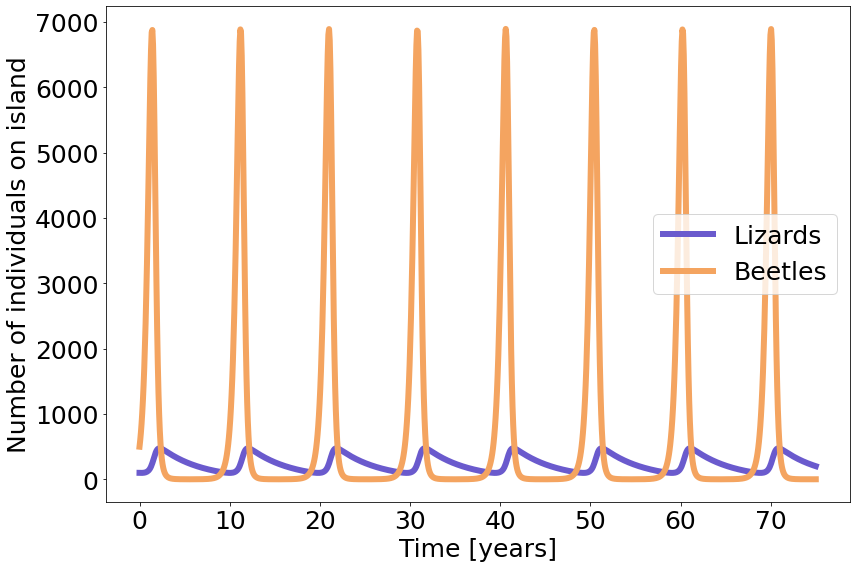

In [6]:
# Solve the system numerically and plot the results as the number of predators and prey as a function of time
print(params)
num_sol = odeint(deriv, state_init, t, args=params).T
P, N = num_sol

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(t, P*V, label="Lizards", color = 'slateblue')
ax.plot(t, N*V, label="Beetles", color = 'sandybrown')

ax.set_xlabel("Time [years]")
ax.set_ylabel("Number of individuals on island")
ax.legend()

print(f'min N: {min(N)*V}')
print(f'min P: {min(P)*V}')
print(f'max N: {max(N)*V}')
print(f'max P: {max(P)*V}')

Text(0.5, 0, 'Number of lizards')

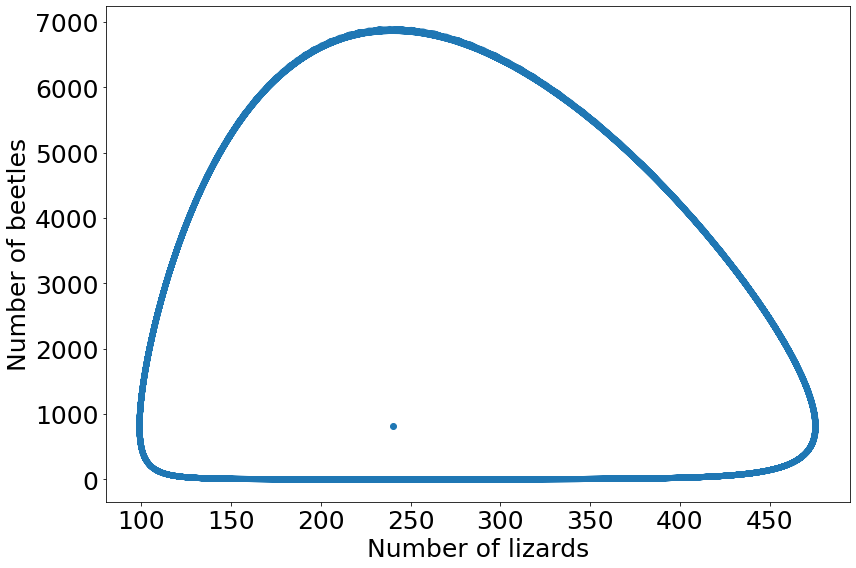

In [7]:
# Solve the system numerically and plot the results the phase portrait (predators vs. prey)

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(P*V, N*V)
ax.scatter(PsV, NsV)
ax.set_ylabel("Number of beetles")
ax.set_xlabel("Number of lizards")

In [8]:
# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# for p in range(40, 200, 20):
#     state_init = (p/V, N0/V)
#     params = (eps, b, d, r)
#     num_sol = odeint(deriv, state_init, t, args=params).T
#     P, N = num_sol
#     ax.plot(P*V, N*V)
# ax.scatter(*[i*V for i in eq])
# ax.set_ylabel("N (prey)")
# ax.set_xlabel("P (pred)")
# ax.legend()

min N: 47.17111762498995
min P: 97.59599307771171
max N: 7200.357198076819
max P: 479.80674492227104


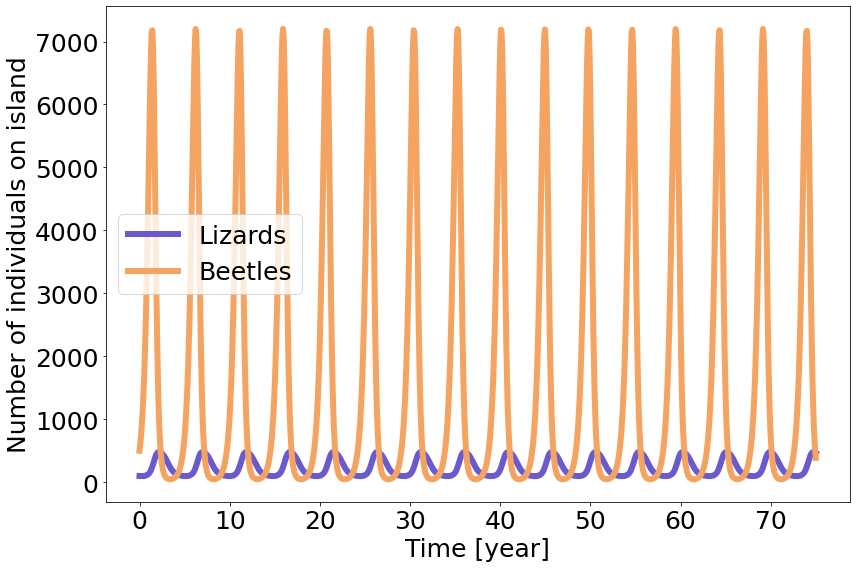

In [9]:
# MORTALITY DUE TO HUNGER

u = 2
def deriv_starve(state, t, *params):
    eps, b, d, r = params
    P, N = state
    dP_dt = eps*b*N*P - d*P - u*P/N
    dN_dt = r*N - b*N*P
    return np.array([dP_dt, dN_dt])

state_init = (P0/V, N0/V)
params = (eps, b, d, r)
num_sol = odeint(deriv_starve, state_init, t, args=params).T
P, N = num_sol

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(t, P*V, label="Lizards", color = 'slateblue')
ax.plot(t, N*V, label="Beetles", color = 'sandybrown')
ax.set_xlabel("Time [year]")
ax.set_ylabel("Number of individuals on island")
ax.legend()

print(f'min N: {min(N)*V}')
print(f'min P: {min(P)*V}')
print(f'max N: {max(N)*V}')
print(f'max P: {max(P)*V}')

In [10]:
# Solve for the equilibrium abundances of prey and predator
Ns = Symbol('Ns')
Ps = Symbol('Ps')
eq = solve([eps*b*Ns*Ps - d*Ps - u*Ps/Ns, r*Ns - b*Ns*Ps])
print(eq)

NsV = 48.1379334055724 * V
PsV = 12 * V
print(NsV, PsV)

[{Ns: -7.58237785001688, Ps: 12.0000000000000}, {Ns: 48.1379334055724, Ps: 12.0000000000000}]
962.758668111448 240


Text(0.5, 0, 'Number of lizards')

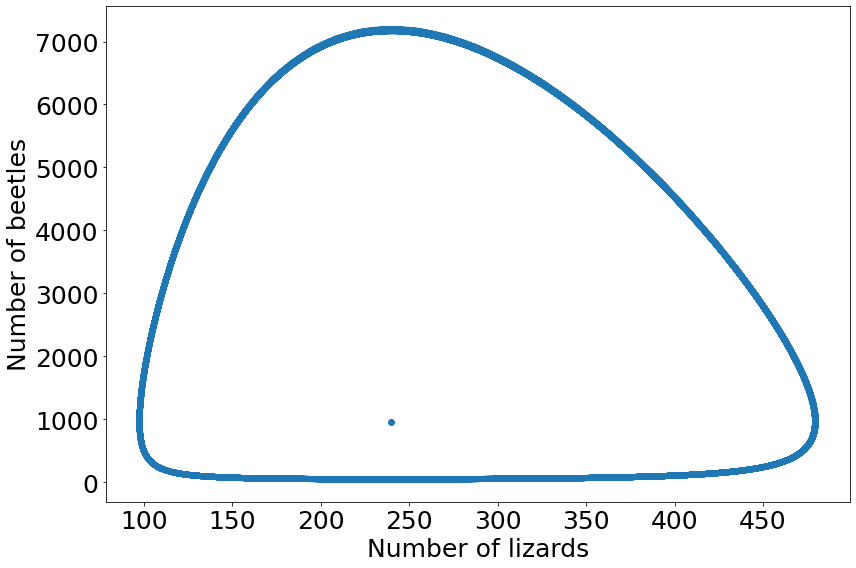

In [11]:
# Solve the system numerically and plot the results the phase portrait (predators vs. prey)
fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(P*V, N*V)
ax.scatter(PsV, NsV)
ax.set_ylabel("Number of beetles")
ax.set_xlabel("Number of lizards")

In [12]:
Ns = Symbol('Ns')
Ps = Symbol('Ps')
epss = Symbol('epss')
bs = Symbol('bs')
ds = Symbol('ds')
rs = Symbol('rs')
us = Symbol('us')

eq2 = solve([epss*bs*Ns*Ps - ds*Ps - us*Ps/Ns, rs*Ns - bs*Ns*Ps])
print(eq2)


[{Ns: (ds - sqrt(4*bs*epss*us + ds**2))/(2*bs*epss), Ps: rs/bs}, {Ns: (ds + sqrt(4*bs*epss*us + ds**2))/(2*bs*epss), Ps: rs/bs}, {Ps: 0, rs: 0}]


In [13]:
# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# for p in range(20, 200, 20):
#     state_init = (p/V, N0/V)
#     params = (eps, b, d, r)
#     num_sol = odeint(deriv_starve, state_init, t, args=params).T
#     P, N = num_sol
#     ax.plot(P, N)
# ax.scatter(*eq)
# ax.set_ylabel("N (prey)")
# ax.set_xlabel("P (pred)")
# # ax.legend()

min N: 3.7776767648047495e-07
min P: 44.21389344366487
max N: 18362.42027264717
max P: 802.3238839139021


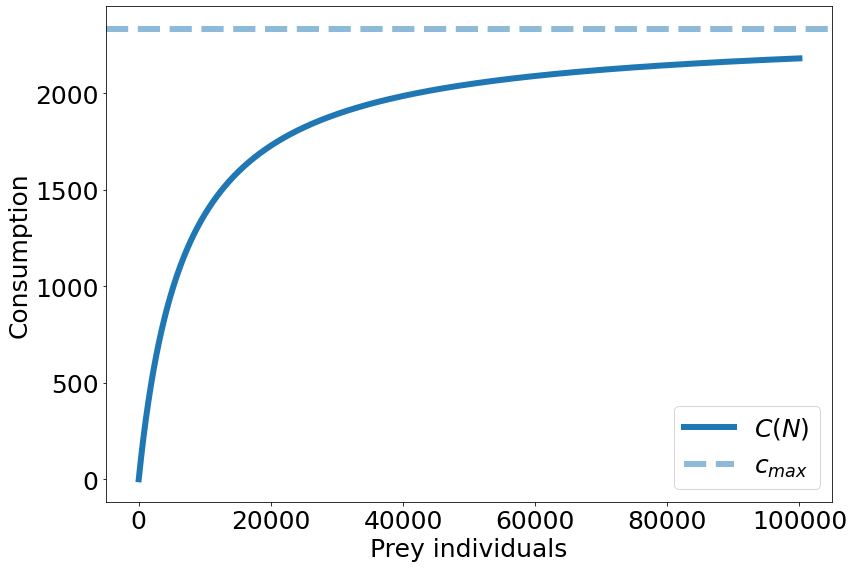

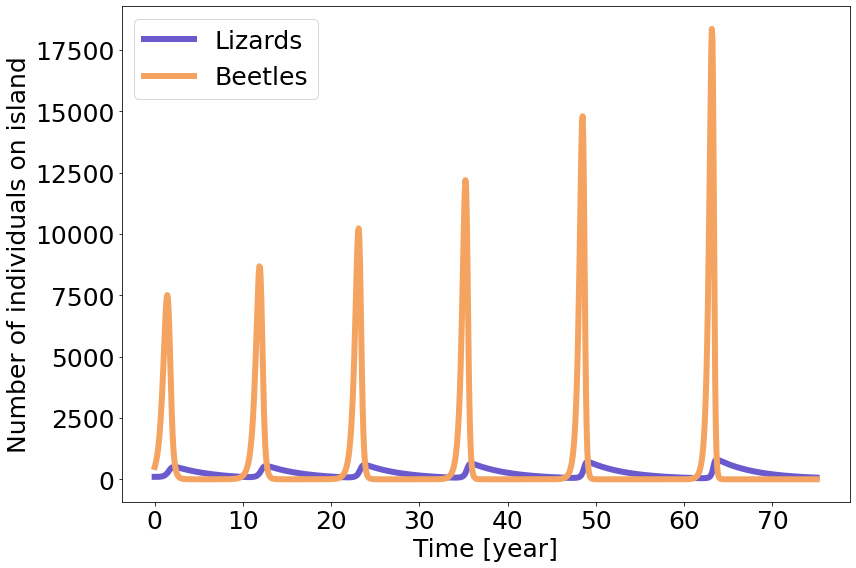

In [14]:
# TYPE II FUNCTIONAL RESPONSE

c_max = b*7e3
C = lambda b, N, c_max: b*N*c_max/(b*N + c_max)

def deriv_type_II(state, t, *params):
    eps, b, d, r = params
    P, N = state
    dP_dt = eps*C(b, N, c_max)*P - d*P
    dN_dt = r*N - C(b, N, c_max)*P
    return np.array([dP_dt, dN_dt])

# print c-N graph
fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(n, (lambda ns: C(b, ns, c_max))(n), label="$C(N)$")
ax.set_xlabel("Prey individuals")
ax.set_ylabel("Consumption")
ax.axhline(c_max, alpha=0.5, linestyle="--", label="$c_{max}$")
ax.legend()


state_init = (P0/V, N0/V)
params = (eps, b, d, r)
num_sol = odeint(deriv_type_II, state_init, t, args=params).T
P, N = num_sol

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(t, P*V, label="Lizards", color = 'slateblue')
ax.plot(t, N*V, label="Beetles", color = 'sandybrown')
ax.set_xlabel("Time [year]")
ax.set_ylabel("Number of individuals on island")
ax.legend()

print(f'min N: {min(N)*V}')
print(f'min P: {min(P)*V}')
print(f'max N: {max(N)*V}')
print(f'max P: {max(P)*V}')

In [15]:
# Solve for the equilibrium abundances of prey and predator
Ns = Symbol('Ns')
Ps = Symbol('Ps')
eq = solve([eps*(b*Ns*c_max/(b*Ns + c_max))*Ps - d*Ps , r*Ns - (b*Ns*c_max/(b*Ns + c_max))*Ps])
print(eq)

NsV = 40.7918895186397 * V
PsV = 12.0699289534605 * V
print(NsV, PsV)

[{Ns: 0.0, Ps: 0.0}, {Ns: 40.7918895186397, Ps: 12.0699289534605}]
815.837790372794 241.39857906921003


Text(0.5, 0, 'Number of lizards')

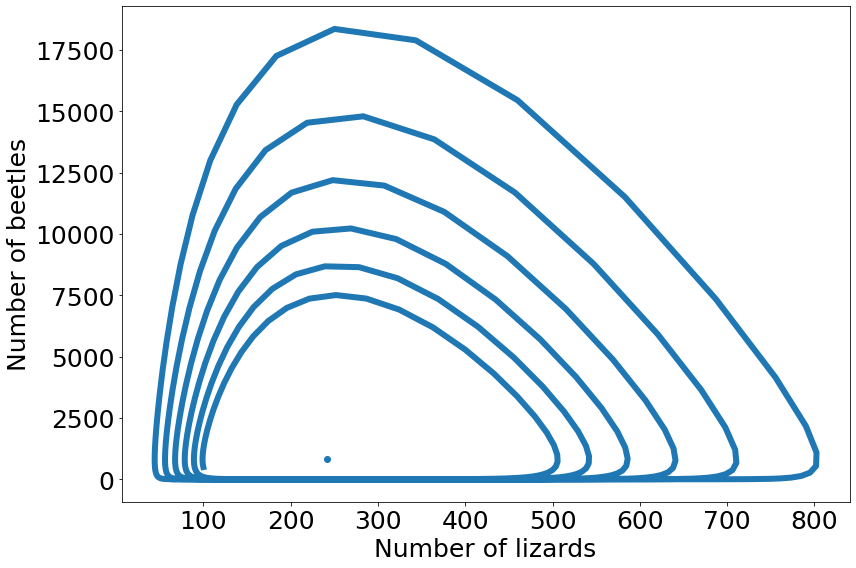

In [16]:
# Solve the system numerically and plot the results the phase portrait (predators vs. prey)
fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(P*V, N*V)
ax.scatter(PsV, NsV)
ax.set_ylabel("Number of beetles")
ax.set_xlabel("Number of lizards")

In [26]:
Ns = Symbol('Ns')
Ps = Symbol('Ps')
epss = Symbol('epss')
bs = Symbol('bs')
ds = Symbol('ds')
rs = Symbol('rs')
us = Symbol('us')
cmaxs = Symbol('cmaxs')

eq2 = solve([epss*(bs*Ns*cmaxs/(bs*Ns + cmaxs))*Ps - ds*Ps, rs*Ns - (bs*Ns*cmaxs/(bs*Ns + cmaxs))*Ps])
print(eq2)


[{Ns: 0, Ps: 0}, {Ns: 0, ds: 0}, {Ns: cmaxs*ds/(bs*(cmaxs*epss - ds)), Ps: cmaxs*epss*rs/(bs*(cmaxs*epss - ds))}, {Ps: 0, rs: 0}]


In [17]:
# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# for p in range(60, 200, 20):
#     state_init = (p/V, N0/V)
#     params = (eps, b, d, r)
#     num_sol = odeint(deriv_type_II, state_init, t, args=params).T
#     P, N = num_sol
#     ax.plot(P, N, alpha=0.4)
# ax.scatter(*eq)
# ax.set_ylabel("N (prey)")
# ax.set_xlabel("P (pred)")
# # ax.legend()

In [18]:
# # Type III functional responce, not used in our report

# c_max = b*7e3
# C = lambda b, N, c_max: ((b*N)**2)*c_max/((b*N)**2 + (c_max)**2)

# def deriv_type_III(state, t, *params):
#     eps, b, d, r = params
#     P, N = state
#     dP_dt = eps*C(b, N, c_max)*P - d*P
#     dN_dt = r*N - C(b, N, c_max)*P
#     return np.array([dP_dt, dN_dt])

# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# ax.plot(n, (lambda ns: C(b, ns, c_max))(n), label="$C(N)$")
# ax.set_xlabel("N (prey)")
# ax.axhline(c_max, alpha=0.5, linestyle="--", label="$c_{max}$")
# ax.axvline(N_eq, label="N_eq")
# ax.legend()

# state_init = (P0/V, N0/V)
# params = (eps, b, d, r)
# num_sol = odeint(deriv_type_III, state_init, t, args=params).T
# P, N = num_sol

# N_eq = np.sqrt(-(c_max**2)*d/((b**2)*(d-eps*c_max)))

# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# ax.plot(t, P*V, label="Predator")
# ax.plot(t, N*V, label="Prey")
# ax.set_xlabel("t [year]")
# ax.legend()

# # print(N_eq)

# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# for p in range(10, 400, 10):
#     state_init = (p/V, N0/V)
#     params = (eps, b, d, r)
#     num_sol = odeint(deriv_type_III, state_init, t, args=params).T
#     P, N = num_sol
#     ax.plot(P, N, alpha=0.4)
# # ax.scatter(*eq)
# ax.set_ylabel("N (prey)")
# ax.set_xlabel("P (pred)")
# ax.axhline(N_eq)
# # ax.legend()

0.053394297464976176
min N: 1.0678859492995234
min P: 100.0
max N: 5221.55331451895
max P: 438.3271629062731


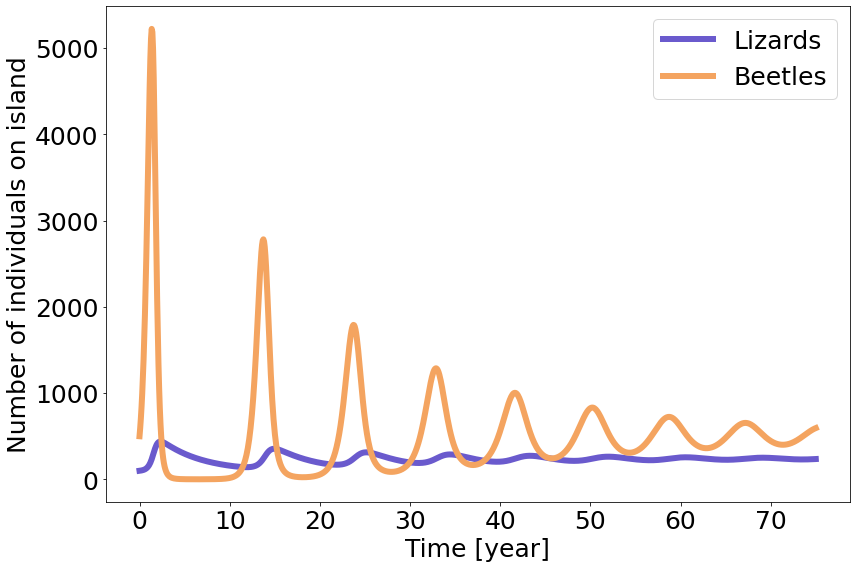

In [19]:
# IMMIGRATION

I = 1
def deriv_immigration(state, t, *params):
    eps, b, d, r = params
    P, N = state
    dP_dt = I + eps*N*b*P - d*P
    dN_dt = r*N - N*b*P
    return np.array([dP_dt, dN_dt])

state_init = (P0/V, N0/V)
params = (eps, b, d, r)
num_sol = odeint(deriv_immigration, state_init, t, args=params).T
P, N = num_sol

print(min(N))

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(t, P*V, label="Lizards", color = 'slateblue')
ax.plot(t, N*V, label="Beetles", color = 'sandybrown')
ax.set_xlabel("Time [year]")
ax.set_ylabel("Number of individuals on island")
ax.legend()

print(f'min N: {min(N)*V}')
print(f'min P: {min(P)*V}')
print(f'max N: {max(N)*V}')
print(f'max P: {max(P)*V}')

In [20]:
# Solve for the equilibrium abundances of prey and predator
Ns = Symbol('Ns')
Ps = Symbol('Ps')
eq = solve([I +eps*b*Ns*Ps - d*Ps, r*Ns - b*Ns*Ps])
print(eq)

NsV = 25.3472222222222 * V
PsV = 12.0000000000000 * V
print(NsV, PsV)

[{Ns: 0.0, Ps: 4.50000000000000}, {Ns: 25.3472222222222, Ps: 12.0000000000000}]
506.944444444444 240.0


Text(0.5, 0, 'Number of lizards')

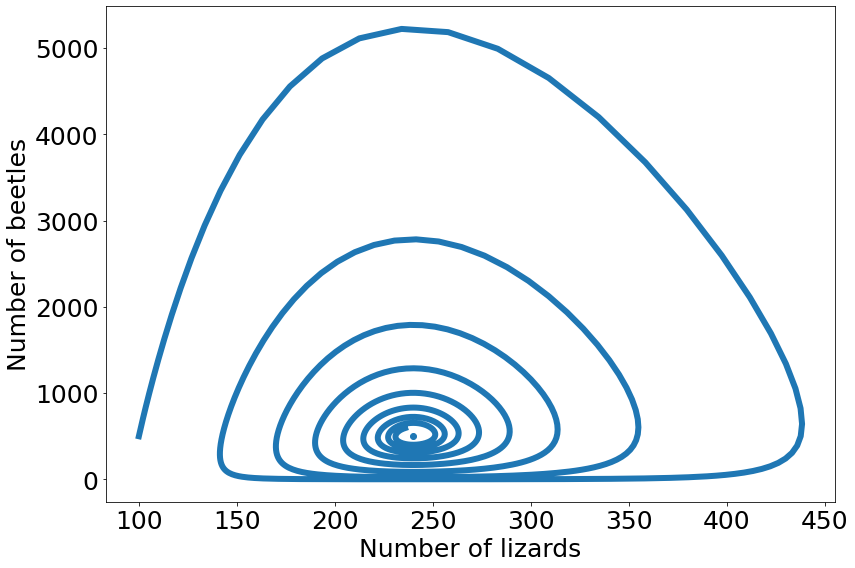

In [21]:
# Solve the system numerically and plot the results the phase portrait (predators vs. prey)
fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(P*V, N*V)
ax.scatter(PsV, NsV)
ax.set_ylabel("Number of beetles")
ax.set_xlabel("Number of lizards")


In [32]:
Ns = Symbol('Ns')
Ps = Symbol('Ps')
epss = Symbol('epss')
bs = Symbol('bs')
ds = Symbol('ds')
rs = Symbol('rs')
us = Symbol('us')
iss = Symbol('iss')

eq2 = solve([epss*bs*Ns*Ps - ds*Ps + iss, rs*Ns - bs*Ns*Ps])
print(eq2)

[{Ns: 0, Ps: iss/ds}, {Ns: (-iss + ds*rs/bs)/(epss*rs), Ps: rs/bs}]


In [22]:
# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# state_init = (P0/V, N0/V)
# params = (eps, b, d, r)
# num_sol = odeint(deriv_immigration, state_init, t, args=params).T
# P, N = num_sol
# ax.plot(P*V, N*V)
# ax.set_ylabel("N (prey)")
# ax.set_xlabel("P (pred)")
# # ax.axhline(N_eq)

# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# for p in range(40, 400, 10):
#     state_init = (p/V, N0/V)
#     params = (eps, b, d, r)
#     num_sol = odeint(deriv_immigration, state_init, t, args=params).T
#     P, N = num_sol
#     ax.plot(P*V, N*V)
# # ax.scatter(*eq)
# ax.set_ylabel("N (prey)")
# ax.set_xlabel("P (pred)")
# # ax.axhline(N_eq)
# # ax.legend()

In [23]:
# # Competition cases, not included in our report

# def deriv_competition(state, t, *params):
#     eps, b, d, r = params
#     b1, b2 = b*1.1, b*1.2
#     P, N1, N2 = state
#     dP_dt = (eps*(N1*b1 + N2*b2) - d)*P
#     dN1_dt = (r - b1*P)*N1
#     dN2_dt = (r - b2*P)*N2
#     return np.array([dP_dt, dN1_dt, dN2_dt])

# state_init = (P0/V, N0/V, N0/V)
# params = (eps, b, d, r)
# num_sol = odeint(deriv_competition, state_init, t, args=params).T
# P, N1, N2 = num_sol

# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# ax.plot(t, P*V, label="Predator")
# ax.plot(t, N1*V, label="Prey1")
# ax.plot(t, N2*V, label="Prey2")
# ax.set_xlabel("t [year]")
# ax.legend()



# def deriv_competition2(state, t, *params):
#     v=0.51
#     eps, b, d, r = params
#     P1, P2, N = state
#     dP1_dt = (eps*N*b*(1-v) - d)*P1
#     dP2_dt = (eps*N*b*v - d)*P2
#     dN_dt = (r - b*(P1*(1-v) + P2*v))*N
#     return np.array([dP1_dt, dP2_dt, dN_dt])

# state_init = (P0/V, P0/V, N0/V)
# params = (eps, b, d, r)
# num_sol = odeint(deriv_competition2, state_init, t, args=params).T
# P1, P2, N = num_sol

# fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
# ax.plot(t, P1*V, label="Predator1")
# ax.plot(t, P2*V, label="Predator2")
# ax.plot(t, N*V, label="Prey2")
# ax.set_xlabel("t [year]")
# ax.legend()


(0.01643835616438356, 0.3333333333333333, 0.2222222222222222, 4.0)
(0.01643835616438356, 0.3333333333333333, 0.2222222222222222, 4.0)


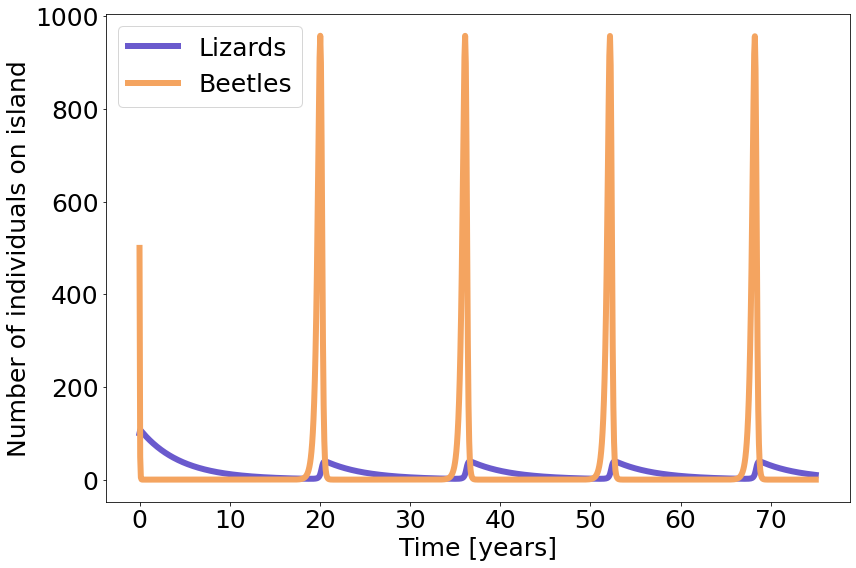

[{Ns: 0.0, Ps: 0.0}, {Ns: 40.5555555555556, Ps: 12.0000000000000}]
810.0 240


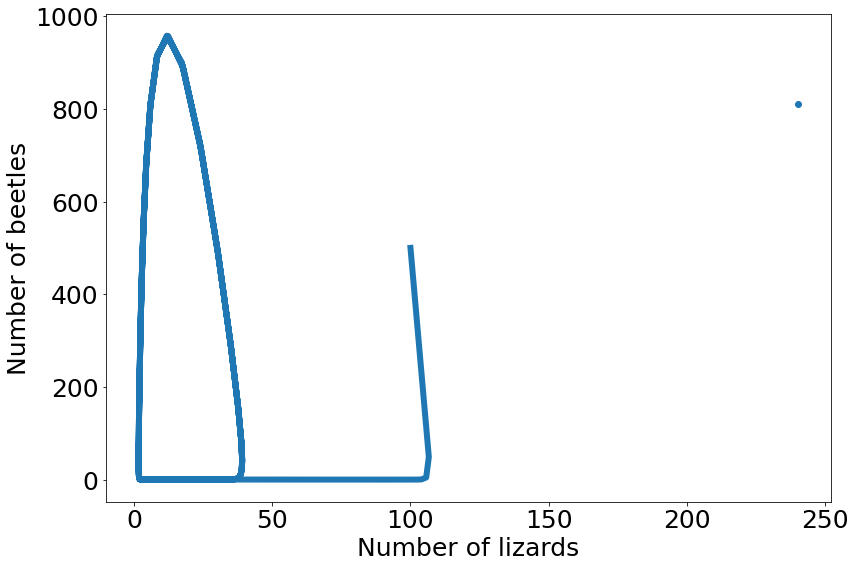

In [24]:
# what happens if I dont use densities?
# ok it definitely looks wrong...

# Setting the parameters:

# P: lizards, the predators
# N: beetles, the prey

yr = 365
t = np.linspace(0, 75, int(1e3)) # time in years
n = np.linspace(0, 1e5, int(1e5)) # N-rage for functional response


# Lizard parameters:
life_years = 4.5 # total lifespan (average)
repr_years = life_years - 2 # lizards mature sexually at 2 years old
clutch_size = 2 # females lay two eggs per clutch
clutch_freq = 2 # females lay two clutches per year

offspring = (clutch_size * clutch_freq) /2 # so, 2 offspring per lizard

feeding_freq = 3 # days until next feeding on beetles
feeding_quant = 1 # beetles at every feeding
feeding_per_year = yr * feeding_quant / feeding_freq # how many beetles a lizard eats (e.g. it eats 122 beetles per year)

eps = offspring / feeding_per_year # efficiency: how many beetles are needed to produce one offspring (e.g. 61 beetles are needed per year)
d = 1 / life_years # death rate : one lizard lives for 4.5 years

# Beetle parameters: 
# They are not very realistic...but I am trying to lower r so that N does not overshoot
N_eggs = 50 # 50 eggs per beetle in their lifetime
N_eggs_survival = 0.1 # 90% of the eggs will get eaten not reach reproductive age
N_d = 1/1 # beetles live for 1 year
r = N_eggs*N_eggs_survival - N_d # growth rate of insects N
#r = 2
# # eps, b, d, r = 1/61, 0.182, 1/4.5, 2

# Island parameters: 
V = 20 # square meters, total area of island

# Clearance rate:
b = 1/(3*1) # let's say that this represents 1 sqm per 3 days per 1 lizard

# Put the needed parameters in a tuple to use in the ODE:
params = (eps, b, d, r)

print(params)

# Initial populations:
N0 = 500
P0 = 100
state_init = (P0, N0) # we input the densities of each population


def deriv(state, t, *params):
    eps, b, d, r = params
    P, N = state
    dP_dt = eps*b*N*P - d*P
    dN_dt = r*N - b*N*P
    return np.array([dP_dt, dN_dt])


# Solve the system numerically and plot the results as the number of predators and prey as a function of time
print(params)
num_sol = odeint(deriv, state_init, t, args=params).T
P, N = num_sol

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(t, P, label="Lizards", color = 'slateblue')
ax.plot(t, N, label="Beetles", color = 'sandybrown')

ax.set_xlabel("Time [years]")
ax.set_ylabel("Number of individuals on island")
ax.legend()
plt.show()

# Solve for the equilibrium abundances of prey and predator
Ns = Symbol('Ns')
Ps = Symbol('Ps')
eq = solve([eps*b*Ns*Ps - d*Ps, r*Ns - b*Ns*Ps])
print(eq)

# This is very stupid, I know, 
# I just do not remember how to  extract the values from the dictionaries inside the list
NsV = 40.5 * V
PsV = 12 * V
print(NsV, PsV)

# Solve the system numerically and plot the results the phase portrait (predators vs. prey)

fig, ax = plt.subplots(1,1, figsize=(12, 8), tight_layout=True)
ax.plot(P, N)
ax.scatter(PsV, NsV)
ax.set_ylabel("Number of beetles")
ax.set_xlabel("Number of lizards")
plt.show()